# Preparación de los datos

### Librerías

In [16]:
import medmnist
from medmnist import INFO
from medmnist.dataset import DermaMNIST

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import dataset_without_pytorch
from dataset_without_pytorch import get_loader

from sklearn.cluster import KMeans

### Carga y preparación de datos DermaMNIST

Carga y prepara el conjunto de datos DermaMNIST. Configura parámetros clave como épocas, tamaño de lote y tasa de aprendizaje, obtiene la clase del dataset (de las 7 existentes), y organiza los datos en un DataLoader para facilitar su procesamiento en lotes.

In [7]:
data_flag = 'dermamnist'
download = True

BATCH_SIZE = 128 #Lote tamanio

info_28 = INFO[data_flag] # Info

# Obtener dinamicamente la clase del conjunto de datos desde un modulo
DataClass_28 = getattr(dataset_without_pytorch, info_28['python_class'])

train_dataset_28 = DataClass_28(split='train', download=download)

# Encapsular los datos en un DataLoader para hacer lotes
train_loader_28 = get_loader(dataset=train_dataset_28, batch_size=BATCH_SIZE)

Using downloaded and verified file: C:\Users\matun\.medmnist\dermamnist.npz


Acceso Directo a Imágenes y Etiquetas del Conjunto de Datos de Entrenamiento

In [8]:
images = train_dataset_28.imgs
labels = train_dataset_28.labels

## Reducción de datos en la clase 5: *Melanocytic Nevi*

Se aplica un reducción de elementos de magenes en la clase 5 dada su sobrerepresentación aplicando el algoritmo K Means para obtener una muestra representativa de 1000 magenes

In [9]:
images_class_5 = [image for image, label in zip(images, labels) if label == 5]

In [10]:
len(images_class_5)

4693

Convertir las imágenes a un formato adecuado para K-means (aplanar cada imagen), dado que las imágenes están en formato (28, 28, 3), las aplanamos a (28 * 28 * 3)

In [11]:
flattened_images = [image.flatten() for image in images_class_5]

Seleccionar las 1000 imágenes representativas

In [13]:
# Aplicar K-means con 1000 clusters
kmeans = KMeans(n_clusters=1000, random_state=42)
kmeans.fit(flattened_images)

# Obtener los centros de los clusters
cluster_centers = kmeans.cluster_centers_

# Para cada centroide, encontrar la imagen más cercana en el conjunto original
selected_images = []
for center in cluster_centers:
    # Calcular la distancia entre el centroide y todas las imágenes
    distances = np.linalg.norm(flattened_images - center, axis=1)
    # Encontrar el índice de la imagen más cercana
    closest_image_index = np.argmin(distances)
    # Añadir la imagen más cercana a la lista de imágenes seleccionadas
    selected_images.append(images_class_5[closest_image_index])


### Reeestructuracon de los datos de entrenamiento

In [14]:
# Filtrar imágenes y etiquetas de todas las clases excepto la clase 5
images_other_classes = [image for image, label in zip(images, labels) if label != 5]
labels_other_classes = [label for label in labels if label != 5]

# Crear etiquetas para las imágenes seleccionadas de la clase 5
selected_labels = [5] * len(selected_images)

# Combinar las imágenes y etiquetas de las otras clases con las seleccionadas de la clase 5
new_images = images_other_classes + selected_images
new_labels = labels_other_classes + selected_labels

Verificamos distribución de los datos

C:\Users\matun\AppData\Local\Temp\ipykernel_12900\3628801159.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_labels_scalar = [int(label) for label in new_labels]


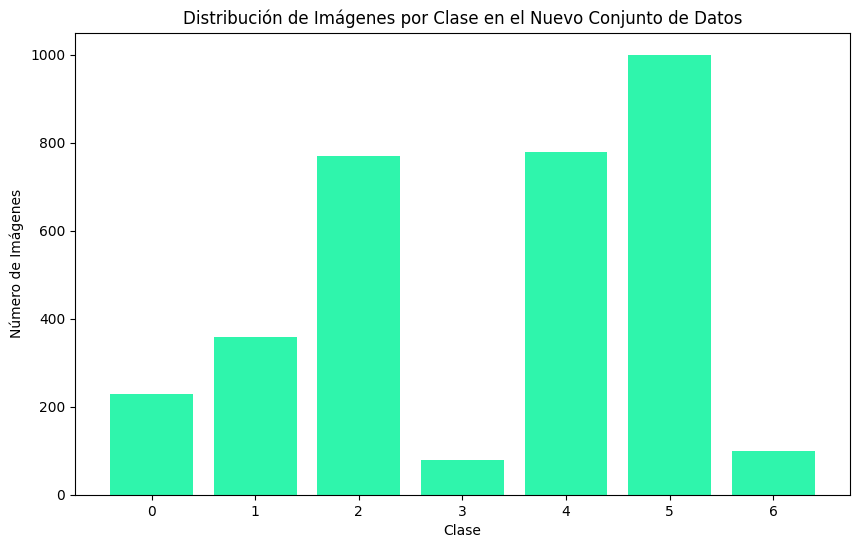

In [21]:
# Asegurarse de que las etiquetas sean valores escalares
new_labels_scalar = [int(label) for label in new_labels]

# Calcular el número de imágenes por clase
unique_classes = set(new_labels_scalar)
class_counts = {cls: new_labels_scalar.count(cls) for cls in unique_classes}

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='#2FF5AC')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.title('Distribución de Imágenes por Clase en el Nuevo Conjunto de Datos')
plt.xticks(list(class_counts.keys()))
plt.show()